# Projet final du Kit Big Data 2022

Vous devez publier votre **notebook exécuté aux formats ipynb et HTML** sur votre github **avant le dimanche 4 décembre 2022 à 23h59** et, lorsque c'est fait, **envoyer une notification par email avec le lien du projet** à l'adresse `contact(at)yotta-conseil.fr`. Il n'est pas utile de publier les fichiers de données utilisés.

### Bon projet !


# Import

In [1]:
import pandas as pd
import re
import os
import numpy as np
import time
import datetime
import requests
from bs4 import BeautifulSoup
from shutil import copyfileobj
from urllib import request
import uuid
import xlwings as xw
from unidecode import unidecode
from datetime import datetime, timedelta
from LatLon23 import *
import seaborn as sns

## 1) Acquisition et chargement des données

### A) Scrapping

Lorsque nous allons sur la page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement. 

Nous pouvons remarquer en inspectant le code source une liste déroulante avec la liste des excels que l'on peut télécharger. On va faire du web scrapping pour essayer de récupérer une sorte d'identifiant de l'excel sous cette forme "20201108_120200" => "date_heure"



In [2]:
def extractRanking (url):
    res = requests.get(url) # requete du site web
    soup = BeautifulSoup(res.content,'html.parser')  # infos de la page
    # on inspecte et on remarque que les tags des excels se trouve dans cette class
    all_ranking = soup.find('select', class_='form__input m--select onsubmit-rank').find_all('option') # les infos se trouvent dans /option
    list_ranking = []
    for rank in all_ranking:
        value_rank = rank.get("value")
        if len(value_rank)!=0:
            list_ranking.append(value_rank)
    return list(set(list_ranking))

On va arranger notre list pour traiter les excel dans l'ordre chronologique

In [3]:
list_ranking = extractRanking ("https://www.vendeeglobe.org/fr/classement")
list_ranking.sort()

### B) Scrapping + Download

Avec les identifiants récupérés avec le web scrapping, nous allons de nouveaux nous connecter sur leur page internet pour cette fois télécharger les Excel.

Les Excel contiennent des images ou un contenu qui empêche de les ouvrir. J'utilise donc la fonction save_with_xlwings qui permet de l'ouvrir avec pandas.

Dans la boucle de téléchargement, j'ouvre l'Excel et je vérifie si un skipper est arrivé. Je ne traiterai pas les Excel avec des skippers arrivé. Le projet est déjà assez compliqué pour moi.



In [92]:
def download_ranking_excel(ranking):
    for i, rank in enumerate(list_ranking):
        url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+str(rank)+'.xlsx'
        filename = 'vendeeglobe_'+str(rank)+'.xlsx'

        with request.urlopen(url) as response, open(filename, 'wb') as out_file:
            copyfileobj(response, out_file)
        save_with_xlwings(filename)
        temp = pd.read_excel(filename)   
        a =list(temp['Unnamed: 1'])
        for j in a:
            if re.search(r'\bARV\b', str(j), re.IGNORECASE):
                return i
                

In [93]:
def save_with_xlwings(file):
    tempfile = file
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile

In [94]:
stop_index_excel = download_ranking_excel(list_ranking)
print(stop_index_excel)

483


Je m'arrete donc au 482 Excel

### C) Creation DataFrame


Pour la concaténation des données, le plus important est de choisir les lignes qui nous intéressent. Nous gardons celle où le rang est un int et celle où le rang vaut RET qui correspond à retirer.

Pour cela je vais créer une colonne 'TAKE' pour chaque excel. Dans celle ci je vais mettre deux valeurs 'YES' ou 'NO'. Quand je concatenerai je mets un condition ou 'TAKE' == YES.

J'ajoute une colonne aussi avec date et l'heure. Je récupère ces valeurs avec l'identifiant de l'Excel en cours de traitement.

In [4]:
def concat_excel(df_vendee_globe_skipper,list_ranking):
    for rank in list_ranking:
        temp = pd.read_excel("vendeeglobe_"+rank+".xlsx")
        temp.insert(0, 'Date excel', temp['Unnamed: 0'])
        temp = temp.rename(columns={'Unnamed: 0':'TAKE'})
        list_test = list(temp['Unnamed: 1'])
        for index, i in enumerate(list_test):
            if type(i) == str:
                if i.strip().isnumeric():  
                    value = 'YES'
                else:
                    if re.search(r'\bRET\b', str(i), re.IGNORECASE):
                        value = 'YES'
                    else:
                        value = 'NO' 
            else:
                value = 'NO' 
            temp.TAKE[index]=value
        
        a =list(temp['Date excel'])
        date = datetime(int(rank[:4]), int(rank[4:6]), int(rank[6:8]), int(rank[9:11]), int(rank[11:13]), int(rank[13:15]))
        for j in range(len(a)):
            temp['Date excel'][j] = date

            
        df_vendee_globe_skipper = pd.concat([df_vendee_globe_skipper, temp[temp.TAKE == 'YES']],ignore_index=True)
    return df_vendee_globe_skipper

In [5]:
list_ranking_race = list_ranking[1:483-1]
df_temp = pd.DataFrame()
df_vendee_globe_skipper = concat_excel(df_temp, list_ranking_race)
df_vendee_globe_skipper.to_csv('df_vendee_globe_skipper.csv') 
df_vendee_globe_skipper.head()

C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date excel,TAKE,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2020-11-08 14:00:00,YES,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,...,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
1,2020-11-08 14:00:00,YES,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,...,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
2,2020-11-08 14:00:00,YES,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,...,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm
3,2020-11-08 14:00:00,YES,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,...,357°,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm
4,2020-11-08 14:00:00,YES,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,...,357°,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm


### D) Caractéristiques des bateaux

Sur le site il est possible de scrapper les caractéristiques techniques des bateaux.

Pas de commentaire particulier, on récupère toutes les infos dans un tuple (nom : valeur') qu'on ajoute dans un DataFrame.

In [6]:
def data_boat(url, verbose=False):

    name_boat = []
    name_skippers = []
    
    req = requests.get(url)
    boat_info = BeautifulSoup(req.content).find_all('div', class_='boats-list__infos')
    
    for boat in boat_info:
        name_boat.append(boat.find('h3').text.strip()) 
        name_skippers.append(boat.find('span').text.strip()) 
  
    spec_boat = BeautifulSoup(req.content).find_all('div', class_='boats-list__popup-infos')
    list_boat = []
    for i, soup_boat_info in enumerate(spec_boat):
        
        boat_inf = soup_boat_info.find_all('li')
        
        boat_characteristics = []       
        for inf in boat_inf:
            a,b = inf.text.split(' : ', maxsplit=1)
            boat_characteristics.append(tuple([a,b]))

        dico_nom_skipper_boat = { "nom_skipper" : name_skippers[i], "Nom bateau" : name_boat[i]}
        dico_nom_skipper_boat.update(boat_characteristics)
        list_boat.append(dico_nom_skipper_boat)

    df_boats = pd.DataFrame(list_boat)
    return df_boats

In [7]:
url = "https://www.vendeeglobe.org/fr/glossaire"
df_boats = data_boat(url)
df_boats.to_csv('df_boats.csv') 

In [8]:
df_boats.head()

,nom_skipper,Nom bateau,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie BEYOU,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


## 2) Préparation des données

### A) Caractéristiques techniques de chacun des voiliers

Dans cette partie, le but est de traiter au mieux nos données pour pouvoir effectuer des analyses le plus facilement possible.

Pour ce traitement et le traitement du data frame des skippers j'essaye de couvrir différentes techniques. Elles sont loin d'être efficientes, mais ça m'a permis de monter en compétences. J'aurais presque tout pu faire en .apply(lambda ...)

Pour cela, nous allons reprendre des méthodes vues lors des cours.

Nous allons changer la date pour l'avoir au format anglophone.

On sépare les noms et prénoms, car les noms me serviront beaucoup en tant qu'index.

On sépare le numéro du bateau et la nationalité, mais je n'utiliserai pas ces données dans la suite.

Pour toutes les valeurs chiffrées, on enlève leur unité pour ne garder que les chiffres.

In [9]:
#import calendar
def convert_date(date):
    jour, mois_le, annee = tuple(date.split())
    dic_month = {'Janvier': "01", 'Février': "02", 'Mars': "03", 'Avril': "04", 'Mai': "05", 'Juin': "06", 'Juillet': "07", 'Août': "08", 'Septembre': "09", 'Octobre': "10", 'Novembre': "11", 'Decembre': "12"}
    # dict((month, index) for index, month in enumerate(calendar.month_abbr) if month)
    mois_ch = dic_month[mois_le]
    return annee+'-'+mois_ch+'-'+jour


In [10]:
def preprocess_boats_characteristics(df_boats):

    df = df_boats.copy()
    
    df['Date de lancement'] = df['Date de lancement'].apply(lambda x: convert_date(x))
    
    # On sépare NOM et Prenom
    # Je vais essayer de faire plusieurs méthode pour m'entrainer ca ne sera pas le plus efficient
    # Ici split
    names = df[list(df.columns)[0]] 
    prenom, nom = [],[]
    for i, name in enumerate(names):
        if len(name.split()) >2:
            p, n, n_bis = name.split()
            nom.append(n+' '+n_bis)
        else:
            p, n = name.split()
            nom.append(n)
        prenom.append(p)       
    df.insert(0, 'Nom', nom)
    df.insert(1, 'Prenom', prenom)
    df = df.drop(columns = ["nom_skipper"])
    
    df.insert(8, 'Nombre de dérives ', df['Nombre de dérives'])
    df.insert(9, 'Voile quille ', df['Voile quille'])
    df = df.drop(columns = ["Voile quille", "Nombre de dérives"])

    # On mets longueur au bon format : des chiffres et ','->'.'   18.28
    liste_colone = ['Longueur', 'Largeur', "Tirant d'eau",'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']
    for j,col in enumerate(liste_colone):
        df[col] = df[col].fillna(" ")
        names = df[list(df.columns)[10+j]]
        for i,name in enumerate(names):
            if col == 'Déplacement (poids)':
                if name == 'NC' or name == 'nc':
                    c = ['0,0']
                    df[col][i] = c[0].replace(',', '.').replace(' ', '')
                else:
                    c = re.findall(r'[^aA-zZ]+', name)
                    df[col][i] = c[0].replace(',', '.').replace(' ', '')
            else: 
                c = re.findall(r'[^aA-zZ]+', name)
                df[col][i] = c[0].replace(',', '.').replace(' ', '')
    

    # On sépare Nationalité et numéro du bateau
    # On va utiliser des regex
    df['Numéro de voile'] = df['Numéro de voile'].fillna("")
    names = df[list(df.columns)[3]] 
    nat, ch = [],[]
    for i, name in enumerate(names):
        n = re.findall(r'([^0-9,]+)', name)
        if len(n)>0:
            nat.append(n[0])
        else:
            nat.append(' ')
        c = re.findall(r'([^A-Z,]+)', name)
        if len(c)>0:
            ch.append(c[0])
        else:
            ch.append(' ')    
            
    df.insert(2, 'Nationalité', nat)
    df.insert(3, 'Numéro du bateau', ch)
    df = df.drop(columns = ["Numéro de voile"])
    
    df = df.fillna("")
    df = df.drop([16])
    return df

In [11]:
df_boats_fixed = preprocess_boats_characteristics(df_boats)
df_boats_fixed.to_csv('df_boats_fixed.csv') 

In [12]:
df_boats_fixed.head()

,Nom,Prenom,Nationalité,Numéro du bateau,Nom bateau,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Nombre de dérives,Voile quille,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
0,AMEDEO,Fabrice,FRA,56,NEWREST - ART & FENÊTRES,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,foils,monotype,18.28,5.85,4.50,7,29,320,570
1,ATTANASIO,Romain,FRA,49,PURE - Best Western®,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,2,acier forgé,18.28,5.80,4.50,9,28,280,560
2,BARRIER,Alexia,FRA,72,TSE - 4MYPLANET,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,2,acier,18.28,5.54,4.50,9,29,260,580
3,BESTAVEN,Yannick,,17,Maître CoQ IV,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,foils,acier mécano soudé,18.28,5.80,4.50,8,29,310,550
4,BEYOU,Jérémie,,08,CHARAL,,VPLP,CDK Technologies,2018-08-18,foils,acier,18.28,5.85,4.50,8,29,320,600


### B) Préparation des données relatives aux classements

De la même manière que precedemment nous allons preprocess au mieux notre DataFrame.

J'essaye de garder le même formalisme qu'avec le DataFrame des bateaux pour faciliter le traitement par la suite.

In [13]:
def process_df_skipper(df_vendee_globe_skipper):
    df = df_vendee_globe_skipper.copy()
    df.rename(columns = {'Unnamed: 1':'Rang','Unnamed: 2':'Voile','Unnamed: 3':'Bateau',\
                                 'Unnamed: 4':'Heure FR','Unnamed: 5':'Latitude','Unnamed: 6':'Longitude',\
                                 'Unnamed: 7':'Cap30m (°)','Unnamed: 8':'Vitesse30m (kts)','Unnamed: 9':'VMG30m (kts)',\
                                 'Unnamed: 10':'Distance30m (mètre)','Unnamed: 11':'Cap (°)','Unnamed: 12':'Vitesse (kts)',\
                                 'Unnamed: 13':'VMG (kts)','Unnamed: 14':'Distance (mètre)','Unnamed: 15':'Cap24h (°)',\
                                 'Unnamed: 16':'Vitesse24h (kts)','Unnamed: 17':'VMG24h (kts)','Unnamed: 18':'Distance24h (mètre)',\
                                 'Unnamed: 19':'DFT (nm)','Unnamed: 20':'DTL (nm)'}, inplace = True)
    
    df = df.drop(columns = ["TAKE"])
    
    df['Rang'] = df['Rang'].apply(lambda x: '-1' if x == 'RET' else x)
    
    # Gestion de la voile
    df['Voile'] = df['Voile'].fillna("")
    names = list(df['Voile'])
    nat, ch = [],[]
    for i, name in enumerate(names):
        nat.append(name.split()[0])
        ch.append(name.split()[1])     
    df.insert(2, 'Nationalité', nat)
    df.insert(3, 'Numéro du bateau', ch)
    df = df.drop(columns = ["Voile"])
    df['Numéro du bateau'] = df['Numéro du bateau'].replace('FRA',np.nan).replace(' ',np.nan)
    
    # Gestion Bateau et nom skipper
    df['Bateau'] = df['Bateau'].fillna("")
    names = list(df['Bateau']) 
    prenom, nom, architecte = [],[], []
    for i, name in enumerate(names):
        temp, temp_archi = name.split('\n')
        architecte.append(temp_archi)
        if len(temp.split())==2:
            prenom.append(temp.split()[0])
            nom.append(temp.split()[1])
        else:
            prenom.append(temp.split()[0])
            a,b = temp.split()[1:3]
            nom.append(a +' '+b)
    df.insert(2, 'Nom', nom)
    df['Nom'] = df['Nom'].str.upper()
    df.insert(3, 'Prenom', prenom)
    df.insert(6, 'Architecte', architecte)
    df = df.drop(columns = ["Bateau"])
    
    # ************ 2 méthodes ************
    # On mets longueur au bon format : des chiffres et ','->'.'   18.28
    # méthode 1 bcp plus longue
    
    # liste_colone = list(df.columns)[10:]
    # for j,col in enumerate(liste_colone):
    #     df[col] = df[col].fillna('')
    #     names = df[list(df.columns)[9+j]] 
    #     for i,name in enumerate(names):
    #         if len(name) ==0:
    #             pass
    #         else:
    #             c = re.findall(r'[^aA-zZ°]+', df[col][i])
    #             df[col][i] = c[0].replace(',', '.').replace(' ', '')
    
    # méthode 2
    liste_cap =['Cap30m (°)', 'Cap (°)', 'Cap24h (°)']
    for j,col in enumerate(liste_cap):
        df[col] = df[col].fillna('')
        df[col] =df[col].apply(lambda x: str(x)[:-1])   
    liste_vitesse = ['Vitesse30m (kts)', 'VMG30m (kts)','Vitesse (kts)', 'VMG (kts)','Vitesse24h (kts)', 'VMG24h (kts)']
    for j,col in enumerate(liste_vitesse):
        df[col] = df[col].fillna('')
        df[col] =df[col].apply(lambda x: str(x)[:-3])  
    liste_nm = ['Distance30m (mètre)','Distance (mètre)','Distance24h (mètre)','DFT (nm)','DTL (nm)']
    for j,col in enumerate(liste_nm):
        df[col] = df[col].fillna('')
        df[col] =df[col].apply(lambda x: str(x)[:-2])  
    #  ************ fin des deux méthodes ************
    df['Heure FR'] = df['Heure FR'].fillna('A')
    names = list(df['Heure FR'])
    heure = []
    for i, name in enumerate(names):
        df['Heure FR'][i] = name.split()[0].replace('A','')
    
    # liste_L = ['Latitude', 'Longitude']
    # for j,col in enumerate(liste_L):
    #     df[col] = df[col].fillna('')
    #     df[col] =df[col].apply(lambda x: str(x)[:-1])  
        
    df['Nom'] = df['Nom'].replace('BOISSIERES', 'BOISSIÈRES')
    return df

In [14]:
df_vendee_globe_skipper_fixed = process_df_skipper(df_vendee_globe_skipper)
df_vendee_globe_skipper_fixed.to_csv('df_vendee_globe_skipper_fixed.csv') 
df_vendee_globe_skipper_fixed.columns

Index(['Date excel', 'Rang', 'Nom', 'Prenom', 'Nationalité',
       'Numéro du bateau', 'Architecte', 'Heure FR', 'Latitude', 'Longitude',
       'Cap30m (°)', 'Vitesse30m (kts)', 'VMG30m (kts)', 'Distance30m (mètre)',
       'Cap (°)', 'Vitesse (kts)', 'VMG (kts)', 'Distance (mètre)',
       'Cap24h (°)', 'Vitesse24h (kts)', 'VMG24h (kts)', 'Distance24h (mètre)',
       'DFT (nm)', 'DTL (nm)'],
      dtype='object')

In [15]:
df_vendee_globe_skipper_fixed.head()

,Date excel,Rang,Nom,Prenom,Nationalité,Numéro du bateau,Architecte,Heure FR,Latitude,Longitude,...,Cap (°),Vitesse (kts),VMG (kts),Distance (mètre),Cap24h (°),Vitesse24h (kts),VMG24h (kts),Distance24h (mètre),DFT (nm),DTL (nm)
0,2020-11-08 14:00:00,1,BURTON,Louis,FRA,18,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,...,357,0.0,0.0,2788.0,201,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 14:00:00,2,HERRMANN,Boris,MON,10,Seaexplorer - Yacht Club De Monaco,15:31,46°24.34'N,01°49.82'W,...,357,0.0,0.0,2787.9,196,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 14:00:00,3,BEYOU,Jérémie,FRA,8,Charal,15:30,46°24.91'N,01°49.99'W,...,357,0.0,0.0,2788.5,199,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 14:00:00,4,RUYANT,Thomas,FRA,59,LinkedOut,15:30,46°24.71'N,01°49.68'W,...,357,0.0,0.0,2788.3,196,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 14:00:00,5,SOREL,Maxime,FRA,53,V And B Mayenne,15:30,46°24.59'N,01°49.56'W,...,357,0.0,0.0,2788.1,195,0.8,0.7,5.8,24294.5,0.6


### C) Rapprochement des données des voiliers avec celle des classements.

Je tente dans un premier temps de concatener les deux tableaux pour voir si je peux l'utiliser.

Pour cela je vais regarder s'il n'y a pas de problème dans les noms des skippers car je souhaite merge sur cette colonne.

In [16]:
# df_boats_fixed[
dict_boats_num = list(set(df_boats_fixed['Nom']))
dict_boats_num.sort()
dict_skipper_num = list(set(df_vendee_globe_skipper_fixed['Nom']))
dict_skipper_num.sort()
print(" Comparaison de la liste de nom : ", len(dict_skipper_num)== len(dict_boats_num))
print(" Comparaison des noms : ", dict_skipper_num== dict_boats_num)

 Comparaison de la liste de nom :  True
 Comparaison des noms :  True


Je vais enlever les colonnes redondantes et je merge sur le nom des skippers.

In [17]:
df_boats_fixed_small = df_boats_fixed.drop(columns=['Prenom','Nationalité','Numéro du bateau', 'Architecte'])
df_skipper_boat = pd.merge(df_vendee_globe_skipper_fixed,df_boats_fixed_small,on='Nom',how='inner')
df_skipper_boat.head()

,Date excel,Rang,Nom,Prenom,Nationalité,Numéro du bateau,Architecte,Heure FR,Latitude,Longitude,...,Date de lancement,Nombre de dérives,Voile quille,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
0,2020-11-08 14:00:00,1,BURTON,Louis,FRA,18,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,...,2015-06-09,foils,acier,18.28,5.80,4.50,7.6,28,300,600
1,2020-11-08 15:00:00,8,BURTON,Louis,FRA,18,Bureau Vallée 2,17:00,46°21.27'N,02°30.26'W,...,2015-06-09,foils,acier,18.28,5.80,4.50,7.6,28,300,600
2,2020-11-08 17:00:00,11,BURTON,Louis,FRA,18,Bureau Vallée 2,18:30,46°21.73'N,03°17.02'W,...,2015-06-09,foils,acier,18.28,5.80,4.50,7.6,28,300,600
3,2020-11-08 21:00:00,8,BURTON,Louis,FRA,18,Bureau Vallée 2,22:30,46°16.47'N,04°47.79'W,...,2015-06-09,foils,acier,18.28,5.80,4.50,7.6,28,300,600
4,2020-11-09 04:00:00,11,BURTON,Louis,FRA,18,Bureau Vallée 2,05:30,46°28.36'N,07°03.84'W,...,2015-06-09,foils,acier,18.28,5.80,4.50,7.6,28,300,600


In [18]:
df_skipper_boat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15868 entries, 0 to 15867
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date excel                    15868 non-null  object
 1   Rang                          15868 non-null  object
 2   Nom                           15868 non-null  object
 3   Prenom                        15868 non-null  object
 4   Nationalité                   15868 non-null  object
 5   Numéro du bateau              14906 non-null  object
 6   Architecte                    15868 non-null  object
 7   Heure FR                      15868 non-null  object
 8   Latitude                      13678 non-null  object
 9   Longitude                     13678 non-null  object
 10  Cap30m (°)                    15868 non-null  object
 11  Vitesse30m (kts)              15868 non-null  object
 12  VMG30m (kts)                  15868 non-null  object
 13  Distance30m (mèt

Notre dataframe est très grand, toutes nos données sont de type 'object'. Il va falloir l'adpater pour bien traiter les données

## 3) Analyses et story telling

### A) Cartes avec les routes d'un ou plusieurs voiliers.

Pour cette analyse on va s'intéresser dans un premier temps aux trajets effectué par les skippers lors de cette course.

Pour cela nous devons transformer notre latitude en longitude dans une autre valeur.

il existe une librairie string2latlon qui permet de transformer les valeurs.

On strip pour obtenir les 3 valeurs plus la coordonnées N, W, S, E

Puis on passe les valeurs dans la fonction string2latlon

In [19]:
def parse_latlon(b):

    res = (b.split('°')[0] + ' ' + b.split('°')[1].split('.')[0] +' ' + b.split('°')[1].split('.')[1].split('\'')[0] + ' '+\
            b.split('°')[1].split('.')[1].split('\'')[1])
    return res

def preproc_latlon(df):
    
    df_res = df.copy()
    df_res.dropna(subset=['Latitude','Longitude' ], inplace=True)
    # Parsing des latitudes et longitudes
    df_res['Lat'], df_res['Long'] = df_res['Latitude'].apply(parse_latlon), df_res['Longitude'].apply(parse_latlon)
    
    df_res['LatLon'] = (df_res['Lat'] + '-' + df_res['Long'])
    df_res['LatLon'] = df_res['LatLon'].apply(lambda x: string2latlon(x.split('-')[0], x.split('-')[1], 'd% %m% %S% %H'))
    df_res['Latitude'] = df_res['LatLon'].apply(lambda x: round(float(x.to_string()[0]), 4))
    df_res['Longitude'] = df_res['LatLon'].apply(lambda x: round(float(x.to_string()[1]), 4))
    del df_res['LatLon']
    
    return df_res

Pour ce qui est du code, j'utilise cartopy. Il y a de nombreux exemples sur leur site plus stack overflow. Je me suis inspiré des différents exemples trouvés.


C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\cartopy\mpl\gridliner.py:531: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\cartopy\mpl\gridliner.py:538: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
C:\Users\gblna\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:4817: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0

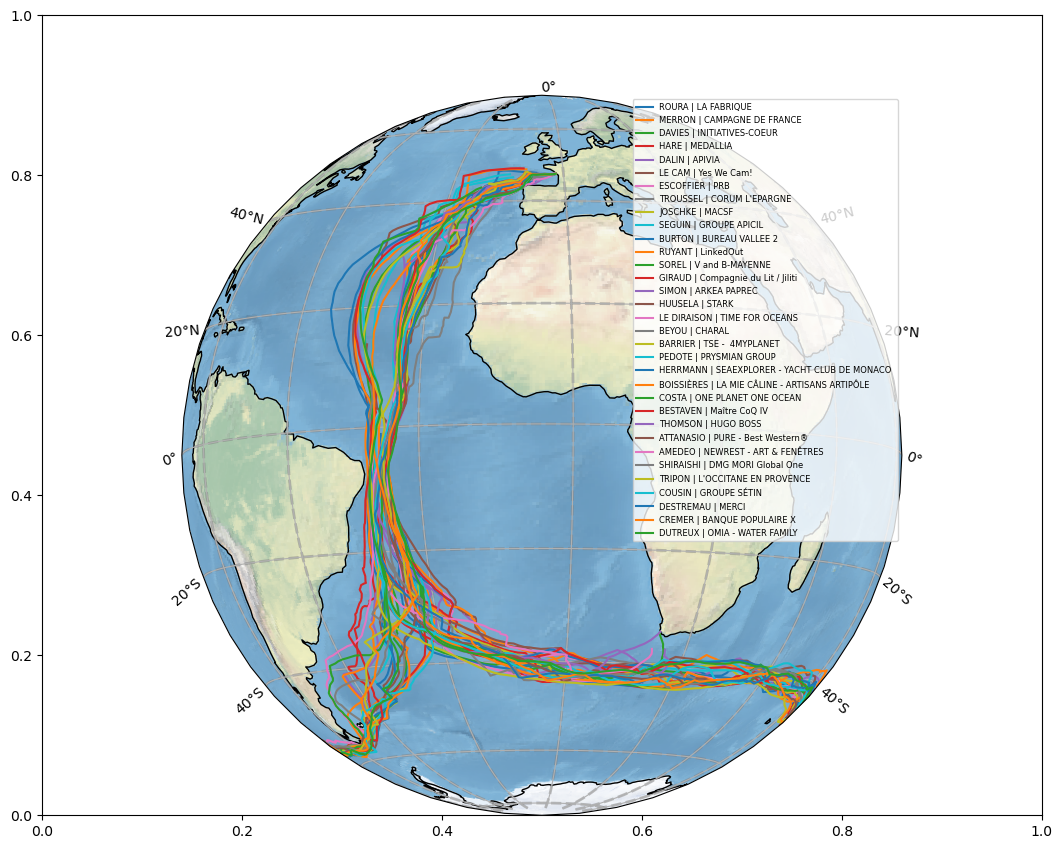

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import cartopy.feature as cfeature

# -------------- Initialisation de la figure ---------------- #
fig = plt.figure(figsize=(10, 8))

ax3 = plt.axes([0,0,1,1])

# Frame map
ax = plt.axes([0.1,0,0.8,0.9], projection=ccrs.Orthographic(central_longitude=-5, central_latitude=-5))
ax.stock_img()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.yformatter = LATITUDE_FORMATTER

colors = sorted(cartopy.feature.COLORS.keys())
handles = []
names = []
for c in colors:
    patch = mpatches.Patch(color=cfeature.COLORS[c], label=c)
    handles.append(patch)
    names.append(c)

df_skipper_boat_new = preproc_latlon(df_skipper_boat)
sub_skippers_select = set(df_skipper_boat['Nom'].values)
for skipper in sub_skippers_select:
    classement_skip = df_skipper_boat_new[df_skipper_boat_new['Nom']==skipper]
    lon = classement_skip['Longitude']
    lat = classement_skip['Latitude']
    bateau = classement_skip['Nom bateau'].unique()[0]

    plot_skip = ax.plot(lon, lat, linestyle='-', transform=ccrs.Geodetic(), label = f'{skipper} | {bateau} ')     
    handles.append(plot_skip)
    names.append(skipper)


ax.set_global()
ax.coastlines()
ax.gridlines()
ax.legend(loc='upper right', prop={'size': 6})
fig.savefig('img/plot_orthographic_30112020.png')
plt.show()

# ********* RUN POUR VOIR LE FICHIER HTML *********

Cette fois ci j'utilise plotly pour avoir une carte interactive html

In [21]:
# Code très largement inspiré des exemples du site de plotly
# https://plotly.com/python/mapbox-layers/ 

import plotly.graph_objects as go
from plotly.offline import plot
import plotly.express as px

test = df_skipper_boat_new


skippers = test['Nom'].unique()
skipper1 = skippers[0]
temp = test[test['Nom']==skipper1]
bateau, prenom, quille, derives  = temp['Nom bateau'].unique()[0], temp['Prenom'].unique()[0], temp['Voile quille '].unique()[0], temp["Nombre de dérives "].unique()[0]

fig = go.Figure(go.Scattermapbox(
        mode = "markers+lines",
        lon = temp['Longitude'].values,
        lat = temp['Latitude'].values,
        name = skipper1,
        hovertemplate = f'<b>Nom bateau</b>: {bateau}<br>' + f"<b>Nombre de derives</b>: {derives}<br>" +
                        f'<b>Voile quille</b>: {quille}<br>' + f'<b>Prenom</b>: {prenom}<br>',
        marker = {'size': 2}))

for skip in skippers[1:len(skippers)]:
    temp = test[test['Nom']==skip]
    bateau = temp['Nom bateau'].unique()[0]
    prenom = temp['Prenom'].unique()[0] 
    quille = temp['Voile quille '].unique()[0]
    derives = temp["Nombre de dérives "].unique()[0]
    fig.add_trace(go.Scattermapbox( mode = "markers+lines", lon = temp['Longitude'].values, lat = temp['Latitude'].values,
        hovertemplate = f'<b>Nom bateau</b>: {bateau}<br>' + f"<b>Nombre de derives</b>: {derives}<br>" +
                        f'<b>Voile quille</b>: {quille}<br>' + f'<b>Prenom</b>: {prenom}<br>' + f'<b>Nom</b>: {skip}<br>',
        name = skip, marker = {'size': 2}))

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[{"below": 'traces', "sourcetype": "raster", "sourceattribution": "United States Geological Survey",
            "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]}])
fig.update_layout(
    autosize = True, margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {'center': {'lon': 10, 'lat': 10}, 'style': "stamen-terrain", 'center': {'lon': -20, 'lat': -20}, 'zoom': 1})

plot(fig, validate = False, filename='plot_race.html',
   auto_open=True)

'plot_race.html'

J'ai réussi d'implémenter deux façons d'afficher les trajets des skippers, néanmoins j'ai un problème au niveau du pole Sud que je n'arrive pas à régler.

### B) Corrélation entre le classement (rang) et la vitesse utile (VMG) des voiliers.

Nous allons nous intéresser à la corrélation entre le rang et la vitesse utile VMG.

Dans un premier temps il faut créer un nouveau DataFrame avec les données qui nous intéressent. Nottament les vitesses moyennes et le rang moyen.

In [22]:
temp = df_skipper_boat.dropna()
temp= temp.astype({'Rang':'int16','Vitesse (kts)':'float32', 'VMG (kts)':'float32'})
df_skipper_boat_moy = temp[['Rang', 'Nom', 'Nom bateau', 'Vitesse (kts)', 'VMG (kts)' ]].groupby(['Nom']).mean(['Rang','Vitesse (kts)', 'VMG (kts)'])\
                                .rename(columns={'Rang':'Rang moy','Vitesse (kts)':'Vitesse (kts) moy','VMG (kts)':'VMG (kts) moy'})
df_skipper_boat_moy = df_skipper_boat_moy.reset_index()
df_skipper_boat_moy.head()

,Nom,Rang moy,Vitesse (kts) moy,VMG (kts) moy
0,AMEDEO,26.965000,10.658500,8.581000
1,ATTANASIO,13.403326,12.637837,11.439293
2,BARRIER,25.141372,10.615593,9.511642
3,BESTAVEN,4.372141,14.407068,12.698337
4,BEYOU,22.386694,13.476507,11.317048


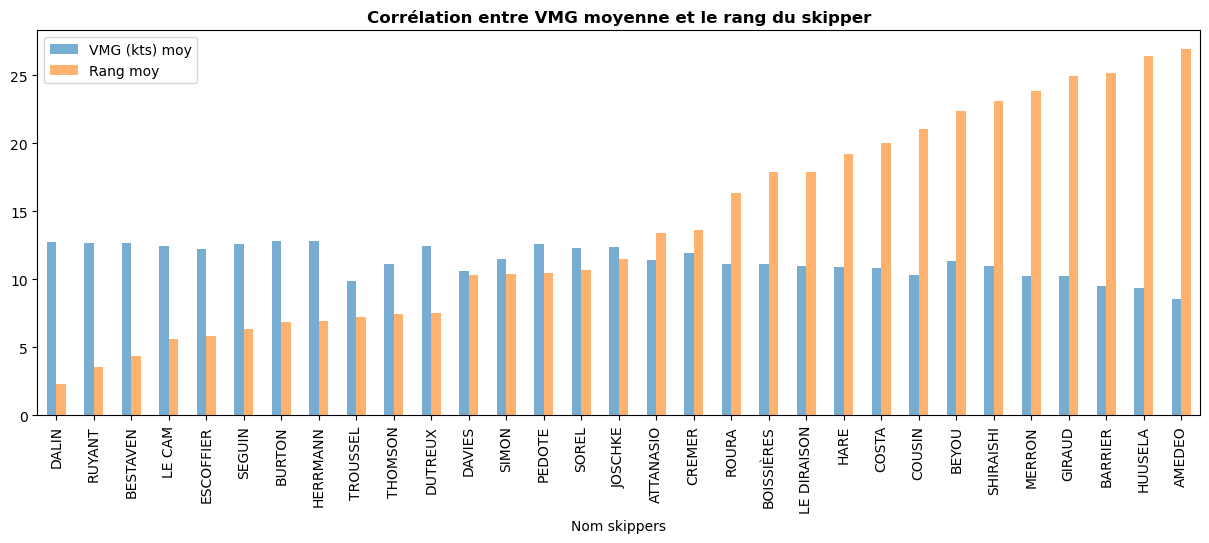

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot1 = df_skipper_boat_moy[['VMG (kts) moy', 'Rang moy', 'Nom']].groupby('Nom').mean(['VMG (kts) moy', 'Rang moy']).sort_values('Rang moy', ascending=True)
plot1.plot.bar(ax=ax, alpha=0.6)
ax.set(xlabel='Nom skippers')
ax.set_title('Corrélation entre VMG moyenne et le rang du skipper', fontweight='bold');


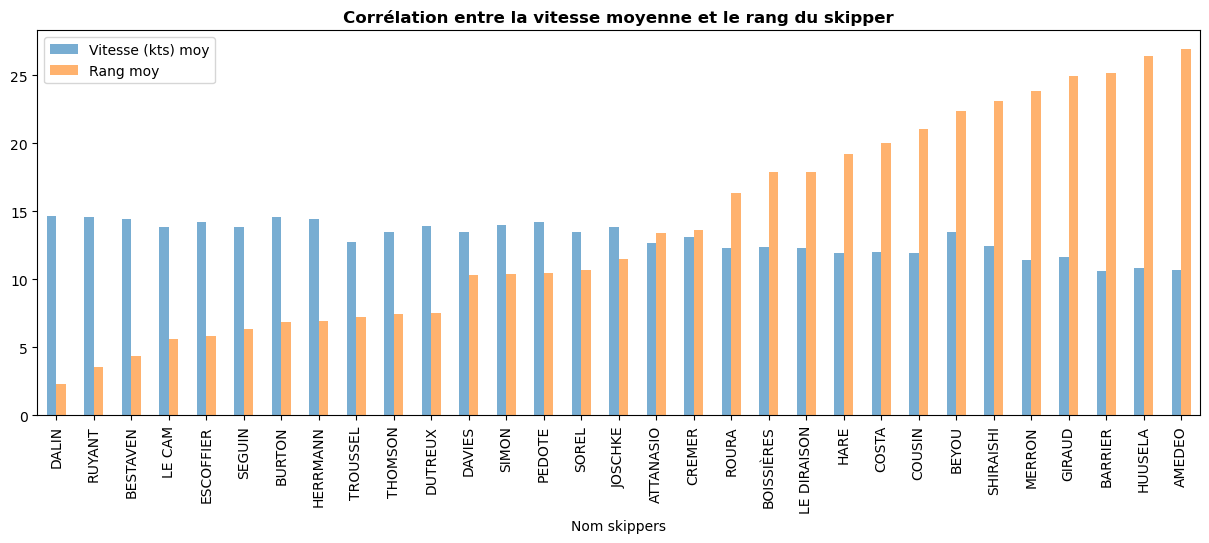

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plot1 = df_skipper_boat_moy[['Vitesse (kts) moy', 'Rang moy', 'Nom']].groupby('Nom').mean(['Vitesse (kts) moy', 'Rang moy']).sort_values('Rang moy', ascending=True)
plot1.plot.bar(ax=ax, alpha=0.6)
ax.set(xlabel='Nom skippers')
ax.set_title('Corrélation entre la vitesse moyenne et le rang du skipper', fontweight='bold');

Que ce soit avec la vitesse moyenne ou la VMG moyenne, on voit une claire corrélation entre les deux variables. Plus la vitesse est élevée plus le skipper se retrouve en tête. Attention c'est le rang moyen donc ce n'est pas totalement lié aux classements.

La VMG (anglais de Velocity made good) est une stratégie de navigation à voile, plus particulièrement de régate. Pour atteindre une route souhaitée, la VMG fait référence à l'optimisation entre la vitesse d'un voilier variable suivant la direction du vent et la distance à parcourir. En français on parle aussi de compromis cap/vitesse.

### C) Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

On s'intéresse à la pésence d'un foil sur la frégate. Quel est son impact.

On preprocess les données des foils en numérique pour pouvoir les traiter.

On réalise un plot similaire à ceux précedent.

In [25]:
def preproc_foil(df):
    ''' Indique la présence ou l'absence d'un foil par un Integer (1 ou 0) '''
    df_res = df.copy()
    dico_foils = {'foils' : 1, '2':0, '2 asymétriques' : 0, 'foiler' : 1}
    df_res['Nombre de dérives '] = df_res['Nombre de dérives '].replace(dico_foils)
    df_res['Nombre de dérives '] = df_res['Nombre de dérives '].apply(lambda x: int(x))
    return df_res

In [26]:
df_skipper_boat_foil = preproc_foil(df_skipper_boat)
df_skipper_boat_foil = df_skipper_boat_foil.dropna()
df_skipper_boat_foil= df_skipper_boat_foil.astype({'Rang':'int16','Vitesse (kts)':'float32', 'VMG (kts)':'float32'})
df_skipper_boat_foil = df_skipper_boat_foil[['Rang', 'Nom', 'Nom bateau', 'Vitesse (kts)', 'VMG (kts)', 'Nombre de dérives ' ]].groupby(['Nom']).mean(['Rang','Vitesse (kts)', 'VMG (kts)', 'Nombre de dérives '])\
                                .rename(columns={'Rang':'Rang moy','Vitesse (kts)':'Vitesse (kts) moy','VMG (kts)':'VMG (kts) moy'})
df_skipper_boat_foil = df_skipper_boat_foil.reset_index()
df_skipper_boat_foil.head()

,Nom,Rang moy,Vitesse (kts) moy,VMG (kts) moy,Nombre de dérives
0,AMEDEO,26.965000,10.658500,8.581000,1.0
1,ATTANASIO,13.403326,12.637837,11.439293,0.0
2,BARRIER,25.141372,10.615593,9.511642,0.0
3,BESTAVEN,4.372141,14.407068,12.698337,1.0
4,BEYOU,22.386694,13.476507,11.317048,1.0


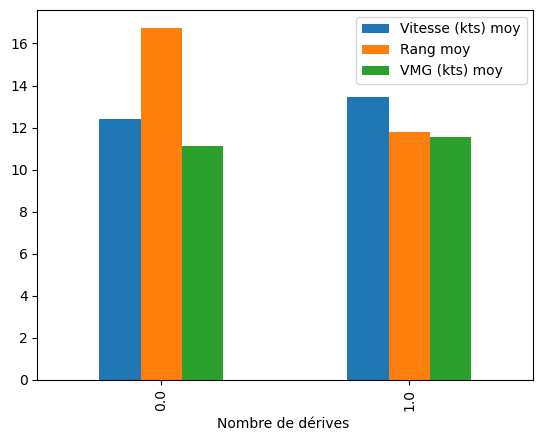

In [49]:
plot1 = df_skipper_boat_foil[['Vitesse (kts) moy', 'Rang moy', 'Nom', 'Nombre de dérives ', 'VMG (kts) moy']].groupby('Nombre de dérives ').mean(['Nombre de dérives ','Vitesse (kts) moy','VMG (kts) moy' ]).sort_values(['VMG (kts) moy','Vitesse (kts) moy','Nombre de dérives '], ascending=True)
plot1.plot.bar()
ax.set(xlabel="Présence ou non d'un foil")
ax.set_title('Impact du foil sur la vitesse et la VMG moyenne ainsi que le rang moyen', fontweight='bold');

Tout d'abord sur ce graphique nous pouvons voir sur l'axe des abscisses que 0.0 corresponds à l'abscende d'un foil.
Nous remarquons ensuite que la présence implique une vitesse moyenne plus élevé. Pour la VMG moyenne, elle est supérieur mais c'est moins flagrant.
Pour ce qui est du rang, un rang moyen plus faible indique une meilleur position au classement général. Nouq avons bien un rang moyen inférieur avec la présence d'un foil.

2 eme graph pour voir l'évolution de la VMG suivant la présence ou non d'un foiler

In [43]:
last_df = preproc_foil(df_skipper_boat)
last_df = last_df.dropna()
last_df =last_df.astype({'VMG (kts)' : 'float32'})
last_df = last_df.loc[last_df['Date excel']>last_df['Date excel'].max()-timedelta(days=8),
                                   ['Date excel','Nom','Rang', 'VMG (kts)', 'Nombre de dérives ']].sort_values(['Date excel'])

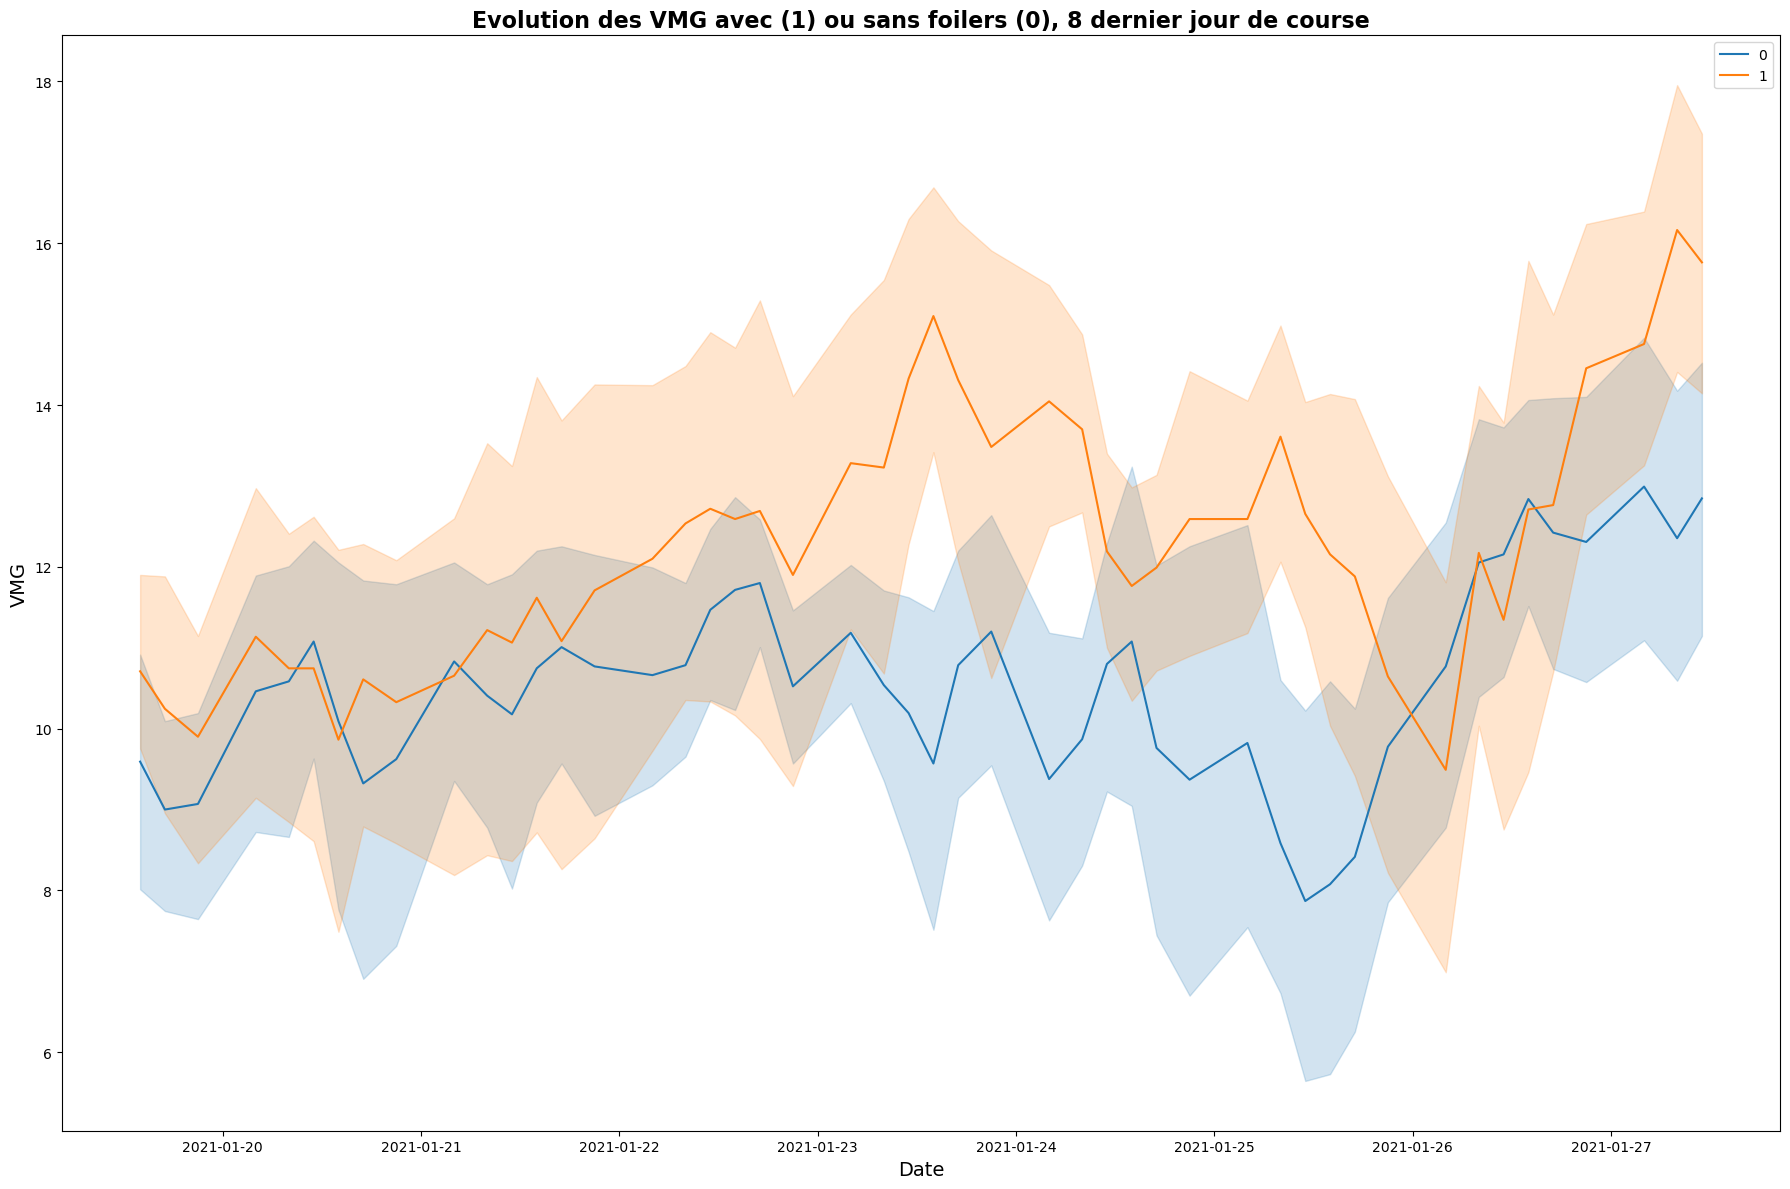

In [46]:
plt.figure(figsize=(18,12))
sns.lineplot(x="Date excel", y="VMG (kts)",
             hue="Nombre de dérives ", 
             data=last_df)
plt.title('Evolution des VMG avec (1) ou sans foilers (0), 8 dernier jour de course', fontsize=16, fontweight="bold")
plt.xlabel('Date', fontsize=14)
plt.ylabel('VMG', fontsize=14)

plt.legend()
plt.tight_layout()

plt.show()

#### Conclusion le foil a un impact important sur les performances des skippers n'en déplaise à LE CAM (même si je partage son point de vue)